In [1]:
from sklearn import metrics
!pip install scipy numpy matplotlib pandas sklearn tabulate seaborn jupyterthemes folium geopy geopandas requests> /dev/null
%matplotlib notebook

In [32]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import json_normalize
from geopy import Nominatim
from pandas import read_csv, read_json
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import json
import itertools
import seaborn as sns
import urllib.request 
from tabulate import tabulate
import requests
import webbrowser
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from IPython.display import display, HTML
# notebook styles
# from jupyterthemes import jtplot
# !jt -t onedork
display(HTML("<style>.container { width:90% !important; }</style>"))
# jtplot.style(theme='onedork')

<h2>Dataset configuration</h2>

In [3]:
class Config(object):
    def __init__(self, dataSourceRaw, dataSourceMapped, useOnlineData, test_size, n_splits, should_describe_data):
        self.dataSourceRaw = dataSourceRaw
        self.dataSourceMapped = dataSourceMapped
        self.useOnlineData = useOnlineData
        self.test_size = test_size
        self.n_splits = n_splits
        self.should_describe_data = should_describe_data

def as_config(dict, dataSetName):
    return Config(
        dict[dataSetName]['dataSourceRaw'],
        dict[dataSetName]['dataSourceMapped'],
        dict[dataSetName]['useOnlineData'],
        dict[dataSetName]['test_size'],
        dict[dataSetName]['n_splits'],
        dict[dataSetName]['should_describe_data'],
    )

In [8]:
json_config = """
{
    "it_data":{
        "dataSourceRaw": "./data/joinit_data.json",
        "dataSourceMapped": "./data/joinit_data.csv",
        "useOnlineData": true,
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    }
}"""
cfg = as_config(json.loads(json_config), 'it_data')
curr_table = []

<h2>Dataset load</h2>

In [9]:
def get_jobs_info(api_url = 'https://justjoin.it/api/offers'):
    headers = {'Content-Type': 'application/json'}
    response = requests.get(api_url, headers=headers)
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None


### Load and map skills

In [10]:
def map_columns_to_csv(dataset):
    skill_map = read_csv('./data/skills_mapped.csv', sep=":")
    unique_skill_columns = (skill_map['mapping'].unique())

    for skill in unique_skill_columns:
        dataset[str(skill)] = 0
    result_df = dataset
    for index, row in dataset.iterrows():
        skill_dict = row['skills']
        for skill_level_tuple in skill_dict:
            name = skill_level_tuple['name']
            mapped_val = np.where(skill_map['Skill'] == name)
            if len(mapped_val) or len(mapped_val[0]) is 0:
                # TEMPORARY HACK
                continue
            name_index_in_map = np.where(skill_map['Skill'] == name)[0][0]
            name = skill_map.iloc[name_index_in_map]['mapping']
            if not name == '-':
                if row[name] == 0:
                    row[name] = skill_level_tuple['level']
                elif not row[name] == 0:
                    row[name] = row[name] if row[name] >= skill_level_tuple['level'] else skill_level_tuple['level']
        result_df.loc[index] = row
    result_df.to_csv(cfg.dataSourceMapped)

def find_exchange_rate(code, table):
    return next(filter(lambda c: c["code"]==code, table[0]["rates"]))["mid"]
def take_only_country_translate_currency(df):
    curr_table = None
    uniq_countries = df['country_code'].nunique()
    uniq_currencies = df['salary_currency'].nunique()
    if uniq_countries != 1 or uniq_currencies != 1:
        print(f"Found {uniq_countries} countries and {uniq_currencies} currencies!")
        print(f"Dropping foreign countries and translating currencies...")
        df = df.loc[df["country_code"] == "PL"]
        if not curr_table:
            with urllib.request.urlopen("https://api.nbp.pl/api/exchangerates/tables/a/?format=json") as url:
                curr_table = json.loads(url.read().decode())
        to_translate = df.loc[df["salary_currency"] != "pln"]
        for curr in to_translate.salary_currency.unique():
            ex_rate = find_exchange_rate(curr.upper(), curr_table)
            df.loc[df["salary_currency"] == curr] = df.loc[df["salary_currency"] == curr].apply(lambda x: x*ex_rate if x.name in ["salary_from", "salary_to"] else ("pln" if x.name == "salary_currency" else x))
        print(f"Unique countries: {df['country_code'].nunique()}, currencies: {df['salary_currency'].nunique()}, observations: {df.shape[0]}")
    return df
    
def read_dataset():
    if cfg.useOnlineData:
        jjit_json = get_jobs_info()
        dataset = json_normalize(jjit_json)
    else:
        dataset = read_json(cfg.dataSourceRaw)
    return read_csv(cfg.dataSourceMapped)

def preprocess_data(df):
    df = df.drop(columns=["street", "address_text", "company_url", "company_logo_url"])
    # Save no-salary observations to separate dataframe: "salaryless_df"
    global salaryless_df
    salaryless_df = df.loc[((df.salary_currency.isnull()) | (df.salary_from.isnull()))]
    df = df.loc[((df.salary_currency.notnull()) & (df.salary_from.notnull()))]
    print(f"Found {salaryless_df.shape[0]} job ads without salary range or currency")
    if cfg.should_describe_data:    
        print(df.shape)
        print(df[["salary_from", "salary_to"]].describe())
    df = take_only_country_translate_currency(df)
    return df
    
def get_dataset():
    return preprocess_data(read_dataset())

<h2>Load (and describe) dataset, create test and train datasets</h2>

In [11]:
df = get_dataset()

Found 277 job ads without salary range or currency
(1116, 75)
        salary_from     salary_to
count   1116.000000   1116.000000
mean   10997.456989  15699.267025
std     4490.979568   5100.746190
min     1250.000000   1750.000000
25%     8000.000000  12000.000000
50%    10000.000000  15980.000000
75%    14000.000000  18600.000000
max    44000.000000  50000.000000
Found 9 countries and 4 currencies!
Dropping foreign countries and translating currencies...
Unique countries: 1, currencies: 1, observations: 1098


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Plot company sizes and salary ranges

Found 75 jobs with salary over 80000, which won't be taken into account on plots below.


<IPython.core.display.Javascript object>


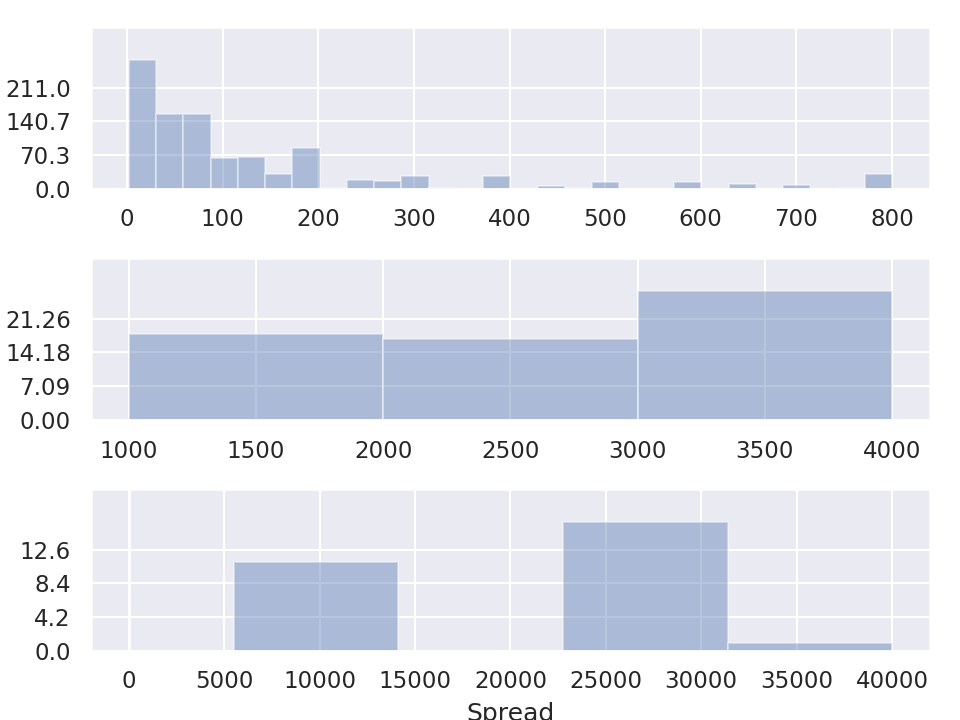

<IPython.core.display.Javascript object>


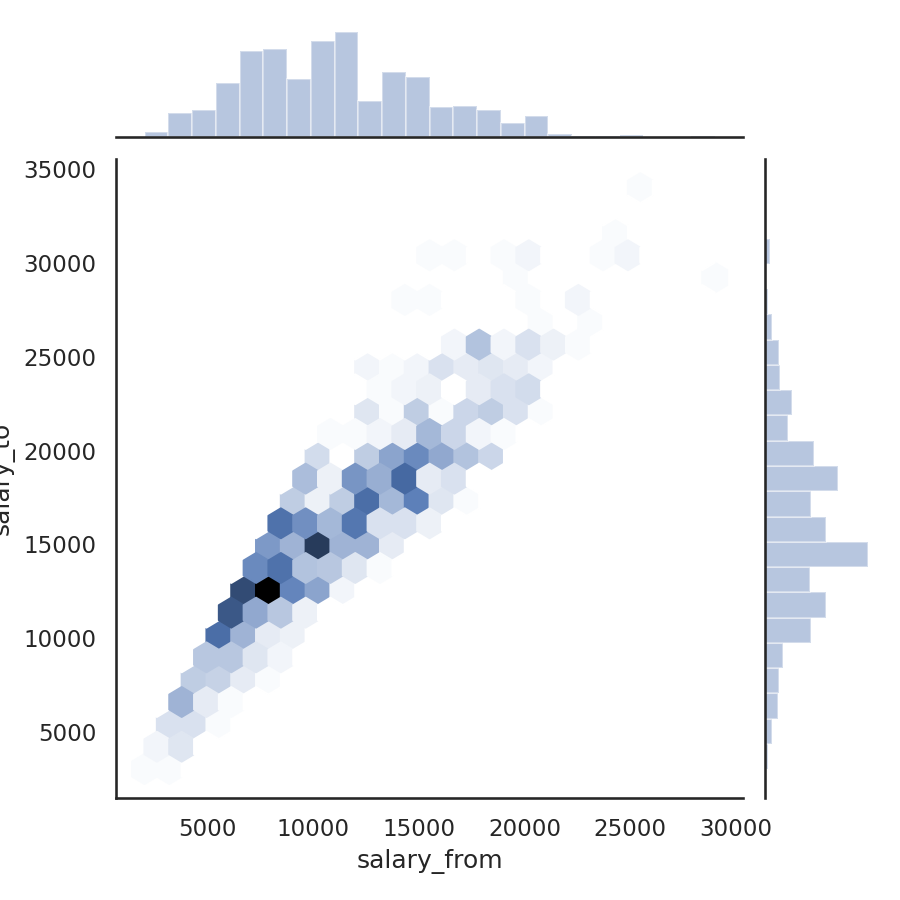

<IPython.core.display.Javascript object>


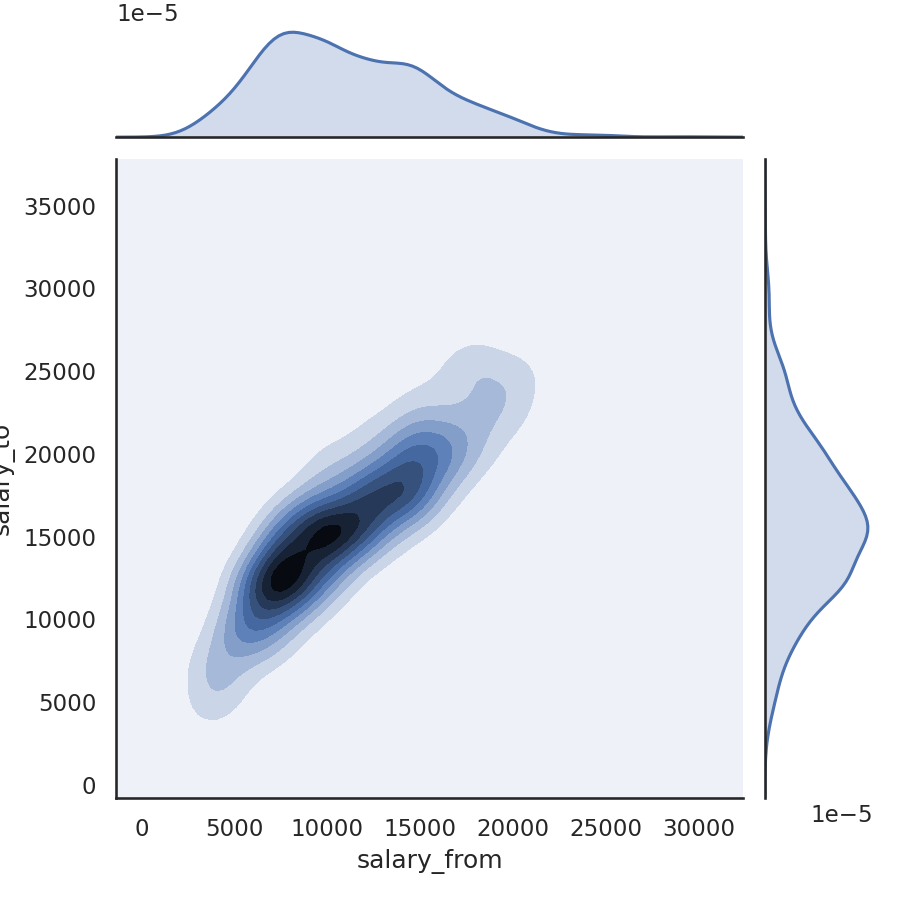

In [12]:
def setAxesRanges(axes):
    for a in axes:
        start, end = a.get_ylim()
        a.yaxis.set_ticks(np.arange(start, end, (end-start)/4))
        a.set_ylim(top=end*1.2)
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)
def transform_company_size(val):
    val = val.replace('+', "").replace("<", "").replace(">", "").replace(" ", "")
    if "-" in val:
        ran = val.split("-", 1)
        if '' in ran:
            return int(ran[0]) if ran[1] == "" else int(ran[1])
        else:
            return (int(ran[0])+int(ran[1]))/2
    else:
        return int(val)
X = df["company_size"].copy().values
X = [transform_company_size(x) for x in X if hasNumbers(x)]
first_X = [x for x in X if x < 1000]
second_X = [x for x in X if x >= 1000 and x < 5000]
third_X = [x for x in X if x >= 5000]

salary_threshold = 80_000
too_high_to_plot_count = df[df.salary_to>=salary_threshold].size
if too_high_to_plot_count > 0:
    print(f"Found {too_high_to_plot_count} jobs with salary over {salary_threshold}, which won't be taken into account on plots below.")
sns.set(color_codes=True)
f, axes = plt.subplots(3, 1)
sns.distplot(first_X, ax=axes[0], kde=False, hist=True);
sns.distplot(second_X, ax=axes[1], kde=False, hist=True);
sns.distplot(third_X, ax=axes[2], kde=False, hist=True);
f.tight_layout()
setAxesRanges(axes)
sns.distplot(df.copy().assign(Spread=lambda df: 100*(df.salary_to-df.salary_from)/((df.salary_to+df.salary_from)/2)).Spread, kde=False, hist=True)
with sns.axes_style("white"):
    without_outlier=df.copy()[df.salary_to<salary_threshold]
    sns.jointplot(x=without_outlier.salary_from, y=without_outlier.salary_to, kind="hex");
    sns.jointplot(x=without_outlier.salary_from, y=without_outlier.salary_to, data=df, kind="kde");

,Count,Percentage
javascript,195,17.8%
java,161,14.7%
php,108,9.8%
mobile,83,7.6%
devops,74,6.7%
net,73,6.6%
python,64,5.8%
testing,62,5.6%
other,46,4.2%
data,36,3.3%


<IPython.core.display.Javascript object>


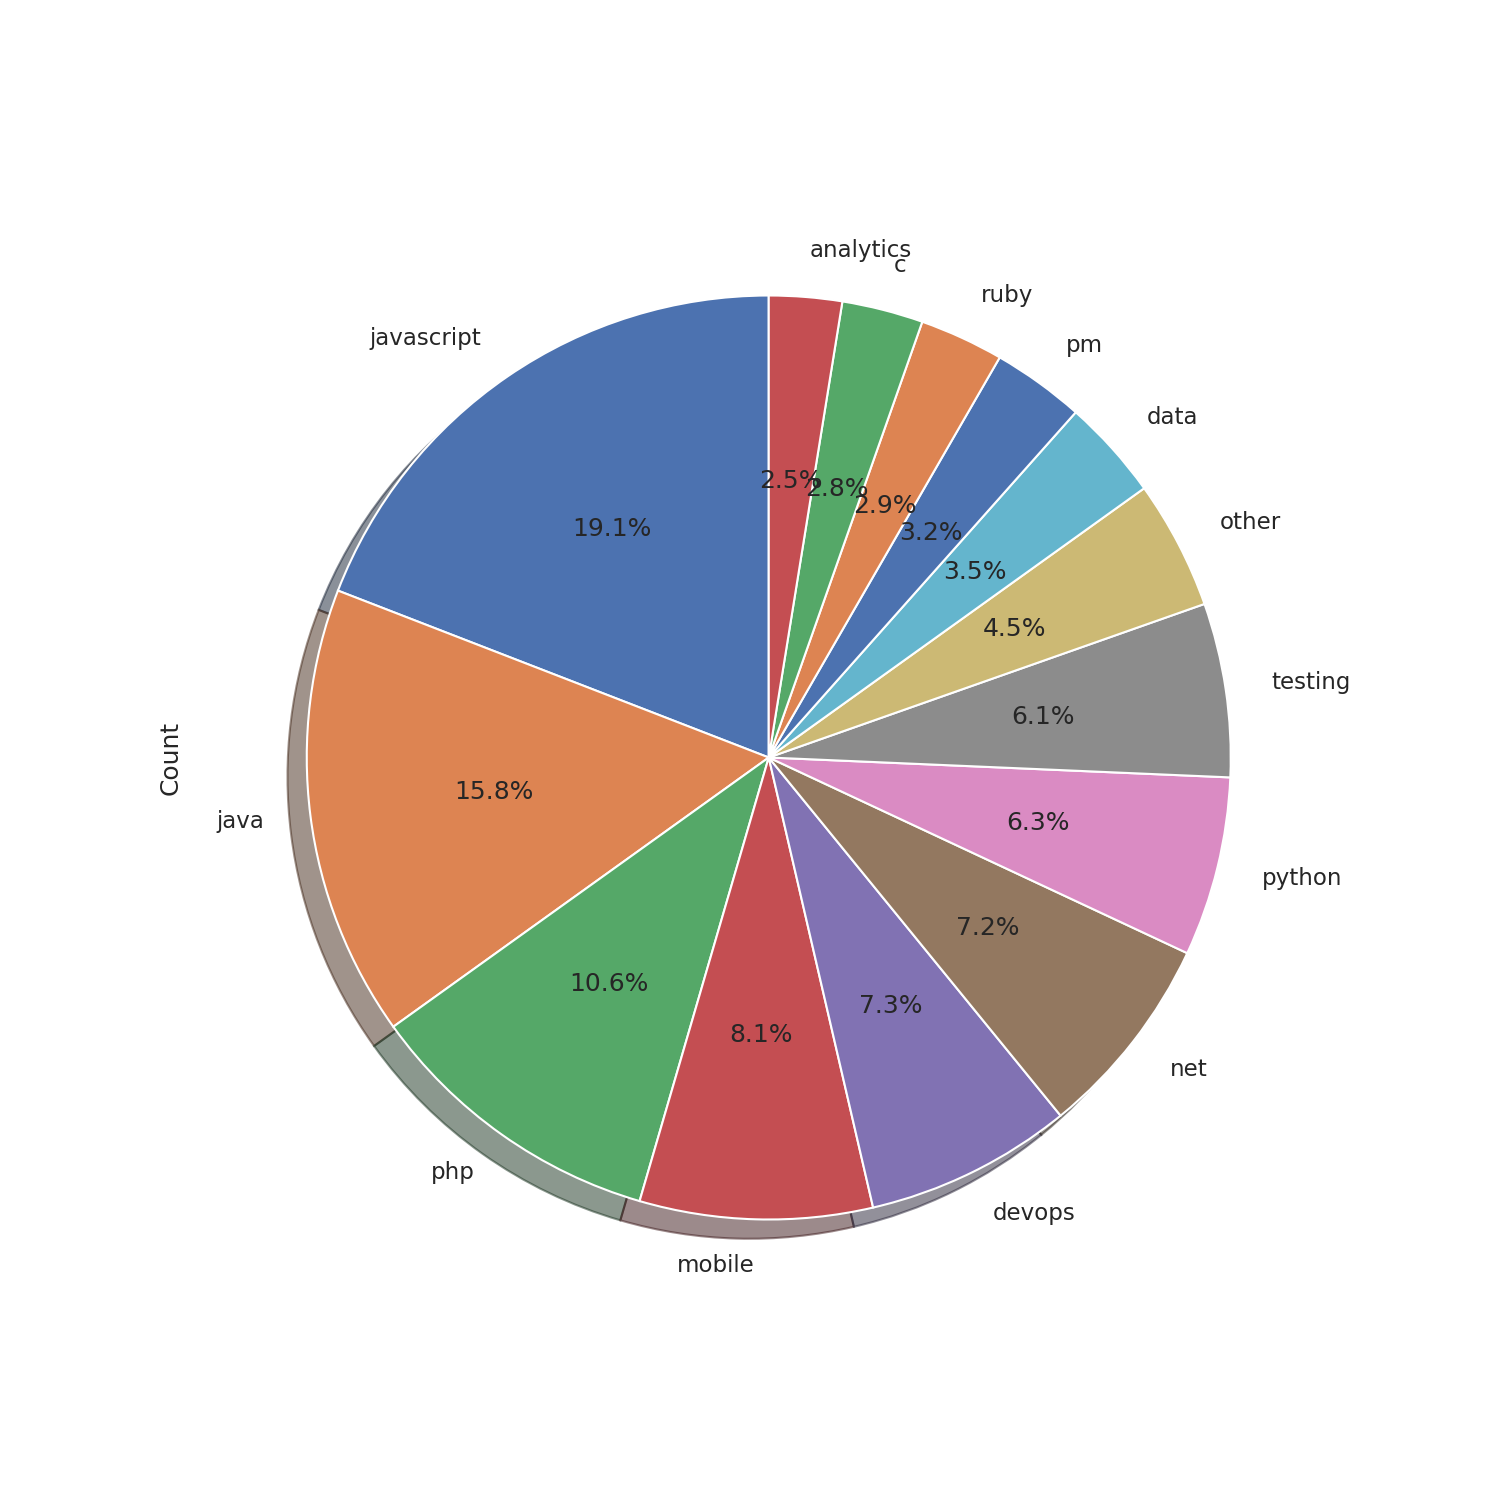

,Count,Percentage
mid,637,58.0%
senior,414,37.7%
junior,47,4.3%


<IPython.core.display.Javascript object>


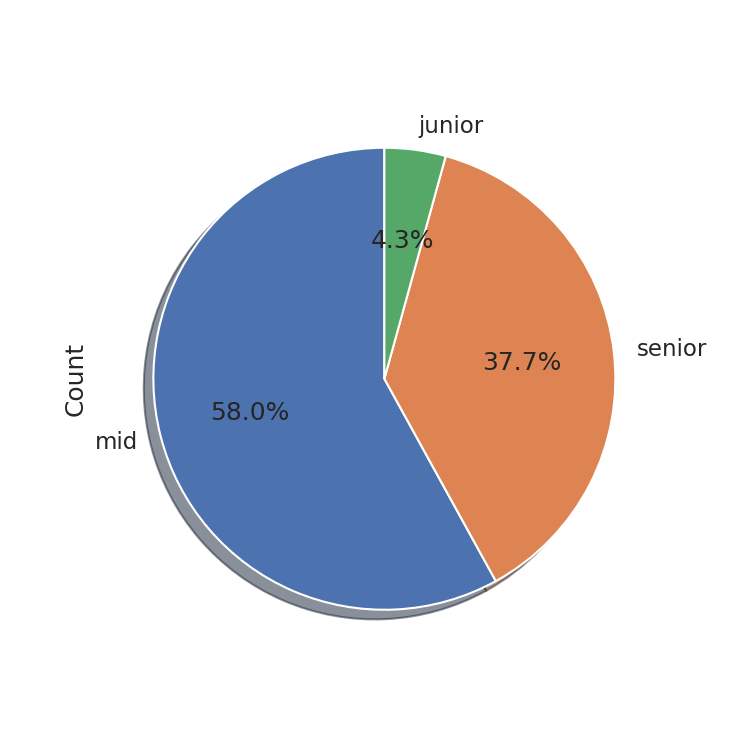

,Count,Percentage
b2b,802,73.0%
permanent,278,25.3%
mandate_contract,18,1.6%


<IPython.core.display.Javascript object>


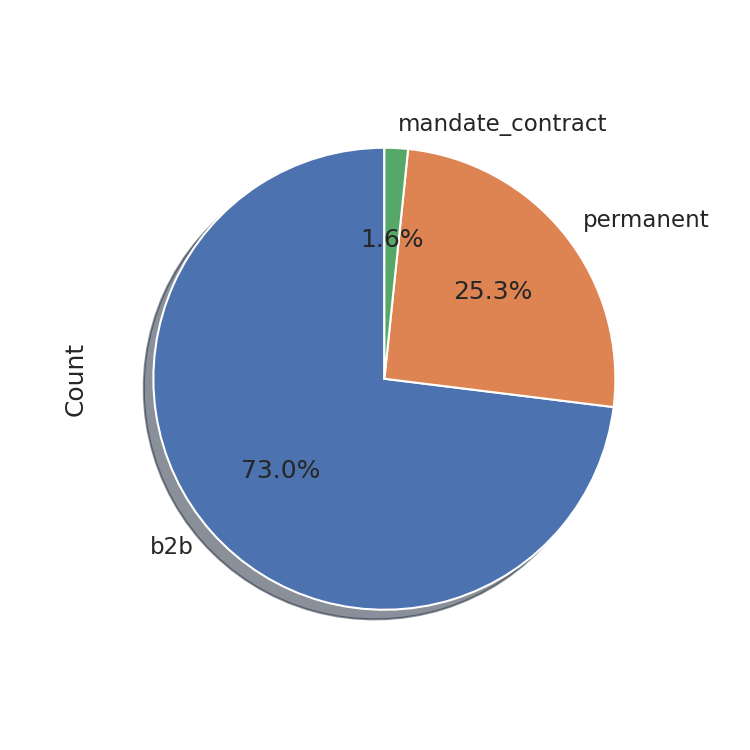

In [13]:
def count_percentage():
    experience_level_count = df['experience_level'].value_counts()
    experience_level_percentage = df['experience_level'].value_counts(normalize=True)
    
    
    marker_icon_count = df['marker_icon'].value_counts()
    marker_icon_percentage = df['marker_icon'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    
    employment_type_count = df['employment_type'].value_counts()
    employment_type_percentage = df['employment_type'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    df1 = pd.DataFrame({'Count': marker_icon_count, 'Percentage': marker_icon_percentage})
    df2 = pd.DataFrame({'Count': experience_level_count, 'Percentage': experience_level_percentage.mul(100).round(1).astype(str) + '%'})
    df3 = pd.DataFrame({'Count': employment_type_count, 'Percentage': employment_type_percentage})
    display(df1)
    df1.copy()[df1.Count>=25].plot.pie(y='Count', legend=False, figsize=(10, 10), autopct='%1.1f%%', shadow=True, startangle=90)
    display(df2)
    df2.plot.pie(y='Count', figsize=(5, 5), legend=False, autopct='%1.1f%%', shadow=True, startangle=90)
    display(df3)
    df3.plot.pie(y='Count', figsize=(5, 5), legend=False, autopct='%1.1f%%', shadow=True, startangle=90)
count_percentage()



---------------------------------------------------------------------------

## Heat maps

In [14]:
lat_column_name = 'lat'
lon_column_name = 'lon'
numerical_column_name = 'no'
province_column_name = 'province'
province_id_column_name = 'province_id'
city_column_name = 'city'
id_column_name = 'id'
country_code_column_name = 'country_code'

<h2>Coordinates load</h2>

In [15]:
def get_province_from_address (address_text, province_string = "województwo ",
                               split_sign=","):
    province = address_text.partition(province_string)[2] 
    province = province.partition(split_sign)[0] 
    
    return province
    
def fill_geo_info(places_data, loc_column_name, fill_province = False):
    locator = Nominatim(user_agent="myGeocoder")
    
    for i, row in places_data.iterrows():
        location = locator.geocode(row[loc_column_name])
        if location is not None:
            places_data.loc[i,lat_column_name] = location.latitude
            places_data.loc[i,lon_column_name] = location.longitude
            if fill_province:
                places_data.loc[i, province_column_name] = get_province_from_address(
                location.address)
        else:
            print(f"Could not find latitude/longitude for {row[loc_column_name]}")
            
    return places_data

<h2>Print heat map methods</h2>

In [16]:
def print_heat_map(places_data, file_path = 'heat_map.html', 
                   heat_column_name = numerical_column_name):

    places_len = len(places_data)
    
    lat = np.array(places_data[lat_column_name][0:places_len])
    lon = np.array(places_data[lon_column_name][0:places_len])
    no = np.array(places_data[heat_column_name][0:places_len],dtype=float)
    data = [[lat[i],lon[i],no[i]] for i in range(places_len)] 
    
    #location is the center location, draw a Map, and start zooming is 6 times.
    map_osm = folium.Map(location=[lat.mean(),lon.mean()],zoom_start=6,control_scale=True)
    HeatMap(data).add_to(map_osm) # Add heat map to the created map
    display(map_osm)
    map_osm.save(file_path) # Save as html file
    webbrowser.open(file_path) # Default browser open

def print_province_heat_map(province_data = None, heat_column_name = numerical_column_name,
                            province_key_column_name = province_id_column_name,
                            file_path = 'province_heat_map.html',
                            legend_name = None):    
    #preprocessing 
    province_data = province_data.dropna()
    province_data[province_id_column_name]=\
        province_data[province_id_column_name].astype(int)
    
    province_geo_paths = get_province_geo_paths()
    province_map = folium.Map([52, 19], zoom_start=6)
    folium.Choropleth(geo_data=province_geo_paths,
                  data=province_data,
                    # kolumna z kluczem, kolumna z wartościami
                  columns=[province_key_column_name, heat_column_name], 
                      # klucz z geoJSON
                  key_on='feature.properties.JPT_KOD_JE', 
                  fill_color='YlOrRd', 
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name=legend_name).add_to(province_map)
    # zapisanie utworzonej mapy do pliku HTML
    display(province_map)
    province_map.save(outfile = file_path)
    webbrowser.open(file_path) # Default browser open
    
def get_province_geo_paths():
    province_shapes = gpd.read_file('wojewodztwa.shp')
    province_shapes = province_shapes[['JPT_KOD_JE', "geometry"]]
    province_shapes['JPT_KOD_JE']=province_shapes['JPT_KOD_JE'].astype(int)
    
    # uproszczenie geometrii (mniejsza wartosc = bardziej dokładnie)
    province_shapes.geometry = province_shapes.geometry.simplify(0.005)
    province_geo_path = province_shapes.to_json()
    return province_geo_path

In [17]:
def group_by_city(data, address_column_name):
    unique_places = data.groupby(address_column_name)[id_column_name].nunique()
    places = pd.DataFrame({city_column_name:unique_places.index,
                           numerical_column_name:unique_places.values})
    places[lat_column_name]=np.nan
    places[lon_column_name]=np.nan
    return places

In [18]:
# print heat map with offer count
grouped_city_data = group_by_city(df, city_column_name)
places_map = fill_geo_info(grouped_city_data, city_column_name)
print_heat_map(places_map)

<h2>Get province data </h2>

In [19]:
def get_province_ids():
    return pd.read_csv('woj_oznaczenia.csv', engine='python')


def get_city_data(data, address_column_name):
    unique_places = data.groupby(address_column_name)[id_column_name].nunique()
    
    places = pd.DataFrame({city_column_name:unique_places.index})
    places[lat_column_name]=np.nan
    places[lon_column_name]=np.nan
    places[province_column_name]=np.nan
    
    return places

In [20]:
places_map = get_city_data(df, city_column_name)
places_map = fill_geo_info(places_map, city_column_name, fill_province=True)

# jjit_data = jjit_data.drop([lat_column_name, lon_column_name, province_column_name])
jjit_data = pd.merge(df, places_map, how='outer', 
                     left_on=city_column_name, right_on=city_column_name)

province_ids = get_province_ids()

<h2>Print heat map for min/max average salary </h2>

In [21]:
#group by province and aggregate min salary
min_salary_per_province_data = jjit_data.groupby(by=province_column_name) \
       .agg({'salary_from':'mean'}) \
       .rename(columns={'salary_from':'mean_salary_from'}) \
       .reset_index()

#merge with province GUGiK data (we need province id)
province_data = pd.merge(min_salary_per_province_data, province_ids, how='outer',
                         left_on=province_column_name, right_on=province_column_name)

print_province_heat_map(province_data = province_data,
                        heat_column_name="mean_salary_from",
                        file_path="min.html",
                        legend_name="Średnie minimalne wynagrodzenia")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
#group by province and aggregate max salary
max_salary_per_province_data = jjit_data.groupby(province_column_name) \
       .agg({'salary_to':'mean'}) \
       .rename(columns={'salary_to':'mean_salary_to'}) \
       .reset_index()

#merge with province GUGiK data (we need province id)
province_data = pd.merge(max_salary_per_province_data, province_ids, how='outer',
                         left_on=province_column_name, right_on=province_column_name)

print_province_heat_map(province_data = province_data,
                        heat_column_name="mean_salary_to",
                        file_path="maks.html",
                        legend_name="Średnie maksymalne wynagrodzenia")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


---------------------------------------------------------------------------

In [23]:
# import difflib
# # temp = dataset['skills'][0]
# skills_arr = []
# # skills = [skill_arr.append() for r in dataset['skills']]
# for r in dataset['skills']:
#     for name in r:
#         skills_arr.append(name['name'])
# unique_skills = np.unique(np.array(skills_arr))
# ## usuwanie po znalezionych podobnych stwierdzeniach
# similar = []
# very_unique = []
# for skill in unique_skills:
#     if not skill in similar:
#         very_unique.append(skill)
#         similar += difflib.get_close_matches(skill, unique_skills, cutoff=0.1)

# ## usuwanie po 1. słowie
# first_word = []
# very_very_unique = []
# for skill in very_unique:
#     if not skill.split(' ')[0] in first_word:
#         first_word.append(skill.split(' ')[0])
#         very_very_unique.append(skill)
# print(len(very_unique))
# pd.DataFrame(very_very_unique).to_csv('./data/skills_double_trim.csv')
# # dataset_skills = read_json(dataset['skills'])

In [25]:
cl_df = df.copy()
for col in ["city", "Unnamed: 0", "title", "company_size", "country_code", "marker_icon", "company_name",
            "latitude", "longitude", "salary_currency", "published_at", "remote_interview", "id",
            "Vert.x", "skills", "-"]:
                cl_df=cl_df.drop(col, axis=1)
print(cl_df.columns)
cols_for_encoding = [c for c in cl_df.select_dtypes(include=['object']).copy().columns if c != "experience_level"]
print(cols_for_encoding)
cl_df = pd.get_dummies(cl_df, columns=cols_for_encoding)

Index(['remote', 'experience_level', 'salary_from', 'salary_to',
       'employment_type', '.NET', 'Design', 'Network', 'REST API', 'Embeded',
       'Cloud', 'Database', 'Android', 'IT', 'Soft Skills', 'Scrum master',
       'Mobile', 'Common', 'JavaScript', 'DevOps', 'Software engineering',
       'Testing', 'Automation', 'Shell Scripting', 'Backend', 'Data Science',
       'Blockchain', 'C++', 'Client Service', 'Front-end', 'Civil Engineering',
       'Developer', 'iOS', 'SQL', 'Python', 'PHP', 'Erlang', 'Scala', 'Git',
       'Games', 'Golang', 'Google', 'Java', 'Web', 'Consultant',
       'Project Manager', 'Analitics', 'CRM', 'Perl', 'R', 'Ruby', 'Rust',
       'SAP', 'CSS', 'XML', 'Salesforce', 'API', 'Data', 'Excel'],
      dtype='object')
['employment_type']


In [30]:
print(len(cl_df.columns))

61


In [33]:
def move_col_to_end(df, col):
    cols_at_end = [col]
    return df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]

cl_df = move_col_to_end(cl_df, "experience_level")
array = cl_df.values
x = array[:,0:len(cl_df.columns)-1]
y = array[:,len(cl_df.columns)-1]
x = normalize(x)
le = LabelEncoder()
y = le.fit_transform(y)
#na podstawie x i y otrzymujemy tablice testowe i wynikowe
x_train, x_validation, y_train, y_validation = train_test_split(x,y, test_size=cfg.test_size, random_state=1)

<h2>Classification models</h2>

In [34]:
models = []
models.extend([
    ('KNN', KNeighborsClassifier(), 0),
    ('CART', DecisionTreeClassifier(), 1),
    ('NB', GaussianNB(), 2),
    ('SVM', SVC(gamma='auto'), 3),
    ('MLP', MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50,10), max_iter=5000), 4)
    ])

<h2>Classification</h2>
kfold - k cross-validation to algorytm polegający na testowaniu nauczania(sprawdzania jego wydajności). 
Zbiór TESTOWY jest dzielony na K podzbiorów. W każdej z k iteracji,
brane jest k-1 pozdbiorów, następuje ich nauczanie, następnie sprawdzenie 'jakości' nauczonego modelu.
Przy pomocy danego algorytmu uczenia maszynowego!

In [35]:
def plot_show():
    pyplot.draw()
    pyplot.pause(0.1)

def get_specificity(y_validate, y_predicted):
    cnf_matrix = confusion_matrix(y_validate, y_predicted)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    TN = TN.astype(float)
        
    return np.mean(TN/(TN+FP))
    
def get_learning_curve(classification_model, training_set_enlarging_step=10):
    train_sizes = np.linspace(0.1, 1, training_set_enlarging_step)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = classification_model,
        X = x,
        y = y, 
        train_sizes = train_sizes,
        cv = 5,
        scoring = 'accuracy')
    return train_sizes, train_scores, validation_scores

def plot_learning_curve(model,name):
    train_sizes, train_scores, test_scores = \
        get_learning_curve(model)

    plt.style.use('seaborn')
    plt.plot(train_sizes, -train_scores.mean(axis = 1), color= 'red', label = 'Training error')
    plt.plot(train_sizes, -test_scores.mean(axis = 1), color= 'navy',label = 'Validation error')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for a %s' % name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()
    
def compare_algorithms(results, names):
    fig = pyplot.figure()
    fig.suptitle("Algorithm Comparison")
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Algorithm Comparison")
    ax.boxplot(results, labels=names)
    plot_show()

def print_scores(cv_results, predictions):
    print('\nMean %f' % cv_results.mean())
    print('STD %f' % cv_results.std())
    print('\nConfusion matrix:')
    print(confusion_matrix(y_validation, predictions))
    print('\nAccuracy %f' % accuracy_score(y_validation, predictions))
    print('Precision %f' % precision_score(y_validation, predictions, average = 'weighted'))
    print('Recall %f' % recall_score(y_validation, predictions, average = 'weighted'))
    print('Specificity %f' % get_specificity(y_validation, predictions))
    print('\nClassification report:')
    print(classification_report(y_validation, predictions))

def plot_roc_curves():
    fig = pyplot.figure()
    ax = plt.gca()
    for name, model, subplot_row in models:
        rfc_disp = plot_roc_curve(model, x_validation, 
                                  y_validation, ax=ax, alpha=0.8)
    plt.show()

def accuracySignificancy(model, x_train, y_train, cv):
    fig = pyplot.figure()
    fig.suptitle("Estimating accuracy score's statistical significancy")
    ax = fig.add_subplot(1,1,1)
    n_classes = np.unique(y_train).size
    score, permutation_scores, pvalue = permutation_test_score(model, x_train, y_train, scoring="accuracy", cv=cv, n_permutations=100)
    print("Classification score %s (pvalue : %s)" % (score, pvalue))
    # View histogram of permutation scores
    ax.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    ax.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Classification Score'
             ' (pvalue %s)' % pvalue)
    ax.plot(2 * [1. / n_classes], plt.ylim(), '--k', linewidth=3, label='Luck')
    ax.set_xlabel('Score')
    plt.show()

def clustering_scores(x, labels_true=None):
    inertias = []
    silhouette_values = []
    calinski_harabasz = []
    davies_bouldin = []
    k_range = 15
    for k in range(2, k_range):
        model = KMeans(n_clusters=k, random_state=1)
        clustering = model.fit(x)
        labels=clustering.labels_
        inertias.append(clustering.inertia_)
        silhouette_values.append(silhouette_score(x, labels))
        calinski_harabasz.append(calinski_harabasz_score(x, labels))
        davies_bouldin.append(davies_bouldin_score(x, labels))

    fig, ax = plt.subplots(4, 1, figsize=(8,32))
    ax[0].plot(inertias)
    ax[0].set_title("Elbow chart")
    ax[0].set_xlabel('clusters')
    ax[0].set_ylabel('distortion')
    ax[1].plot(silhouette_values)
    ax[1].set_title("Silhouette score")
    ax[1].set_xlabel('clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[2].plot(calinski_harabasz)
    ax[2].set_title("Calinski Harabasz score")
    ax[2].set_xlabel('clusters')
    ax[2].set_ylabel('Calinski Harabasz score')
    ax[3].plot(davies_bouldin)
    ax[3].set_title("Davies Bouldin score")
    ax[3].set_xlabel('clusters')
    ax[3].set_ylabel('Davies Bouldin score')
    plt.tight_layout()
    plt.show()

def evaluate_per_dataset():
    results = []
    names = []
    
    for name, model, subplot_row in models:
            print(f"---------------------------\nRunning classification for: {name}")
#             kfold = StratifiedKFold(n_splits=cfg.n_splits, random_state=1, shuffle=True)
            kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
            cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
            accuracySignificancy(model, x_train, y_train, kfold)
            results.append(cv_results)
            names.append(name)

            # Make predictions on validation dataset
            model.fit(x_train, y_train)
            predictions = model.predict(x_validation)
            
            print_scores(cv_results, predictions)
            plot_learning_curve(model,name)
    #ROC
    plot_roc_curves()

    # Compare Algorithms - ROC etc
    compare_algorithms(results, names)
    
    clustering_scores(x)

In [ ]:
evaluate_per_dataset()

---------------------------
Running classification for: KNN


<IPython.core.display.Javascript object>

Classification score 0.6207191780821917 (pvalue : 0.009900990099009901)

Mean 0.620719
STD 0.024320

Confusion matrix:
[[ 2  2  1]
 [ 3 84 38]
 [ 1 34 55]]

Accuracy 0.640909
Precision 0.644665
Recall 0.640909
Specificity 0.767483

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.70      0.67      0.69       125
           2       0.59      0.61      0.60        90

    accuracy                           0.64       220
   macro avg       0.54      0.56      0.55       220
weighted avg       0.64      0.64      0.64       220

---------------------------
Running classification for: CART


<IPython.core.display.Javascript object>

Classification score 0.6514684516396845 (pvalue : 0.009900990099009901)

Mean 0.648049
STD 0.016214

Confusion matrix:
[[ 2  3  0]
 [ 4 99 22]
 [ 0 36 54]]

Accuracy 0.704545
Precision 0.705854
Recall 0.704545
Specificity 0.800546

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.72      0.79      0.75       125
           2       0.71      0.60      0.65        90

    accuracy                           0.70       220
   macro avg       0.59      0.60      0.59       220
weighted avg       0.71      0.70      0.70       220

---------------------------
Running classification for: NB


<IPython.core.display.Javascript object>

Classification score 0.6092673308426733 (pvalue : 0.009900990099009901)

Mean 0.609267
STD 0.035526

Confusion matrix:
[[ 2  2  1]
 [ 3 75 47]
 [ 1 11 78]]

Accuracy 0.704545
Precision 0.745068
Recall 0.704545
Specificity 0.825107

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.85      0.60      0.70       125
           2       0.62      0.87      0.72        90

    accuracy                           0.70       220
   macro avg       0.60      0.62      0.60       220
weighted avg       0.75      0.70      0.70       220

---------------------------
Running classification for: SVM


<IPython.core.display.Javascript object>

Classification score 0.5831465338314653 (pvalue : 1.0)

Mean 0.583147
STD 0.001328

Confusion matrix:
[[  0   5   0]
 [  0 125   0]
 [  0  90   0]]

Accuracy 0.568182
Precision 0.322831
Recall 0.568182
Specificity 0.666667

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.57      1.00      0.72       125
           2       0.00      0.00      0.00        90

    accuracy                           0.57       220
   macro avg       0.19      0.33      0.24       220
weighted avg       0.32      0.57      0.41       220



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------------------------
Running classification for: MLP


<IPython.core.display.Javascript object>